In [54]:
# ===================================================================
# FDA FAERS 2025Q1 Adverse Event Data Quality Analysis
# ===================================================================
# Source: FDA FAERS Database, Quarter 1 2025 (Jan-Mar 2025)
# Analysis Date: [Current Date]
# Analyst: [Your Name]

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# ===================================================================
# 1. DATA LOADING AND SETUP
# ===================================================================

# Load FAERS 2025Q1 demographic data
demo_df = pd.read_csv('data/DEMO25Q1.txt', delimiter='$', encoding='latin-1', low_memory=False)

print(f"FDA FAERS 2025Q1 Dataset Loaded")
print(f"Total Records: {len(demo_df):,}")
print(f"Data Period: January 1 - March 31, 2025")

FDA FAERS 2025Q1 Dataset Loaded
Total Records: 400,514
Data Period: January 1 - March 31, 2025


In [56]:
# ===================================================================
# 2. MISSING DEMOGRAPHICS ANALYSIS
# ===================================================================

# Analyze missing data patterns across critical demographic fields
total_rows = len(demo_df)
missing_analysis = demo_df.isnull().sum().sort_values(ascending=False)
missing_percent = (missing_analysis / total_rows * 100).round(1)

print("\n=== MISSING DATA ANALYSIS ===")
print("Critical demographic fields missing data:")
for col in ['sex', 'age_grp', 'wt', 'wt_cod', 'age', 'age_cod']:
    if col in missing_analysis.index:
        count = missing_analysis[col]
        pct = missing_percent[col]
        print(f"{col}: {count:,} missing ({pct}%)")

# Define records missing ALL critical demographics
all_missing_demo = demo_df[
    demo_df['sex'].isna() & 
    demo_df['age_grp'].isna() & 
    demo_df['wt'].isna()
]

print(f"\n=== KEY FINDING ===")
print(f"Records missing ALL demographics (sex, age_grp, weight): {len(all_missing_demo):,}")
print(f"Percentage of total dataset: {len(all_missing_demo)/total_rows*100:.1f}%")


=== MISSING DATA ANALYSIS ===
Critical demographic fields missing data:
sex: 81,778 missing (20.4%)
age_grp: 259,903 missing (64.9%)
wt: 331,751 missing (82.8%)
wt_cod: 331,752 missing (82.8%)
age: 156,970 missing (39.2%)
age_cod: 156,950 missing (39.2%)

=== KEY FINDING ===
Records missing ALL demographics (sex, age_grp, weight): 68,106
Percentage of total dataset: 17.0%


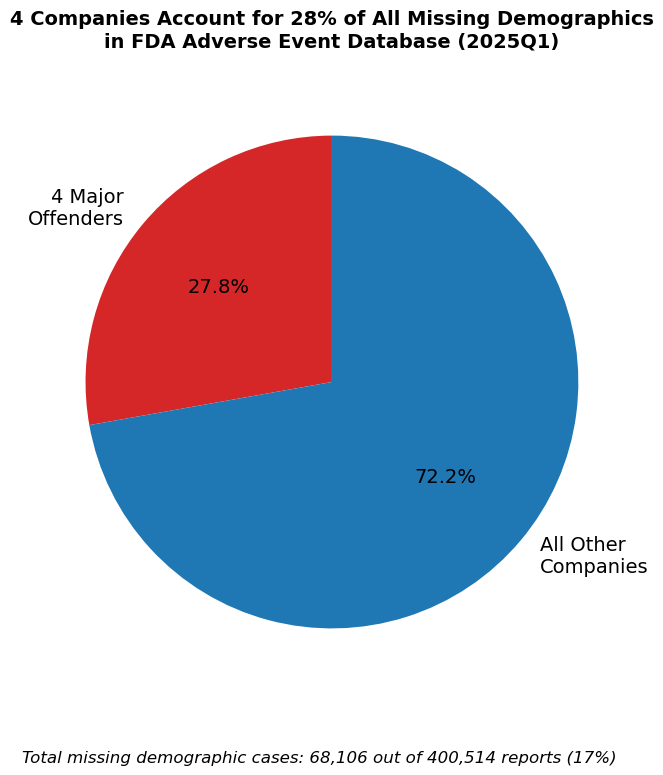

In [ ]:
# Show 4 companies = 28% of entire problem
labels = ['4 Major\nOffenders', 'All Other\nCompanies']
sizes = [27.8, 72.2]
colors = ['#d62728', '#1f77b4']

fig, ax = plt.subplots(figsize=(10, 8))
wedges, texts, autotexts = ax.pie(sizes, labels=labels, autopct='%1.1f%%', 
                                  colors=colors, startangle=90, textprops={'fontsize': 14})
ax.set_title('4 Companies Account for 28% of All Missing Demographics\nin FDA Adverse Event Database (2025Q1)', 
             fontsize=14, fontweight='bold', pad=20)

# Add context
plt.figtext(0.5, 0.02, f'Total missing demographic cases: 68,106 out of 400,514 reports (17%)', 
            ha='center', fontsize=12, style='italic')

# Save figure to disk
plt.savefig("images/missing_data_pie.png", dpi=300, bbox_inches='tight')
plt.show()

In [64]:
# ===================================================================
# 3. DATA QUALITY ISSUES DISCOVERED
# ===================================================================

print("\n=== DATA QUALITY ISSUES ===")

# Date validation - impossible dates
event_dates = pd.to_datetime(demo_df['event_dt'], format='%Y%m%d', errors='coerce')
future_dates = event_dates > pd.Timestamp.now()
ancient_dates = event_dates < pd.Timestamp('1950-01-01')

print(f"Events in the future: {future_dates.sum()}")
print(f"Events before 1950: {ancient_dates.sum()}")
print(f"Date range: {demo_df['event_dt'].min()} to {demo_df['event_dt'].max()}")
print(f"Spanning {2444-1025} years (1025 AD to 2444 AD)")

# Weight validation - impossible weights
extreme_weights = demo_df[(demo_df['wt'] > 227) & (demo_df['wt_cod'] == 'KG')]
print(f"\nPatients over 227kg (500lbs): {len(extreme_weights)}")
print(f"Maximum weight: {demo_df['wt'].max()} kg ({demo_df['wt'].max() * 2.2:.0f} lbs)")

# Example: The impossible case
baby_elephant = demo_df[(demo_df['age'] == 19) & (demo_df['age_cod'] == 'DY') & (demo_df['wt'] == 3912)]
if not baby_elephant.empty:
    print(f"Found: 19-day-old baby weighing 3,912 kg (8,606 lbs)")

# Report code validation
invalid_rpt_codes = demo_df['rept_cod'].isin(['5DAY', '30DAY']).sum()
print(f"\nInvalid report codes (timeline instead of type): {invalid_rpt_codes:,} ({invalid_rpt_codes/total_rows*100:.1f}%)")



=== DATA QUALITY ISSUES ===
Events in the future: 6
Events before 1950: 4
Date range: 10250101.0 to 24441101.0
Spanning 1419 years (1025 AD to 2444 AD)

Patients over 227kg (500lbs): 59
Maximum weight: 3912.0 kg (8606 lbs)
Found: 19-day-old baby weighing 3,912 kg (8,606 lbs)

Invalid report codes (timeline instead of type): 8,269 (2.1%)


In [59]:
# ===================================================================
# 4. AGE GROUP CLASSIFICATION SYSTEM
# ===================================================================

def derive_age_group_with_teens(row):
    """
    Derive standardized age group from age and age_cod fields
    N = Neonate (0-27 days)
    I = Infant (28 days - 23 months) 
    C = Child (2-11 years)
    T = Teen (12-17 years)
    A = Adult (18-64 years)
    E = Elderly (65+ years)
    """
    if pd.isna(row['age']) or pd.isna(row['age_cod']):
        return None
    
    age = row['age']
    unit = row['age_cod']
    
    # Convert to years for classification
    if unit == 'DY':
        age_in_years = age / 365.25
    elif unit == 'WK':
        age_in_years = age / 52.18
    elif unit == 'MON':
        age_in_years = age / 12
    elif unit == 'YR':
        age_in_years = age
    elif unit == 'DEC':
        age_in_years = age * 10
    else:
        return None
    
    # Age group classification
    if age_in_years < (28/365.25):
        return 'N'  # Neonate
    elif age_in_years < 2:
        return 'I'  # Infant
    elif age_in_years < 12:
        return 'C'  # Child
    elif age_in_years < 18:
        return 'T'  # Teen
    elif age_in_years < 65:
        return 'A'  # Adult
    else:
        return 'E'  # Elderly

# Apply age group classification
demo_df['derived_age_grp'] = demo_df.apply(derive_age_group_with_teens, axis=1)

# Calculate classification accuracy
total_with_both = len(demo_df.dropna(subset=['age_grp', 'derived_age_grp']))
perfect_matches = (demo_df['age_grp'] == demo_df['derived_age_grp']).sum()
accuracy = perfect_matches / total_with_both * 100
recoverable = (demo_df['age_grp'].isna() & demo_df['derived_age_grp'].notna()).sum()

print(f"\n=== AGE GROUP CLASSIFICATION RESULTS ===")
print(f"Classification Accuracy: {accuracy:.1f}%")
print(f"Recoverable missing classifications: {recoverable:,}")


=== AGE GROUP CLASSIFICATION RESULTS ===
Classification Accuracy: 99.7%
Recoverable missing classifications: 129,858


In [75]:
# ===================================================================
# 5. PHARMACEUTICAL COMPANY COMPLIANCE ANALYSIS
# ===================================================================

print("\n=== PHARMACEUTICAL COMPLIANCE ANALYSIS ===")

# Calculate missing demographic rates by manufacturer
total_by_mfr = demo_df['mfr_sndr'].value_counts()
missing_by_mfr = all_missing_demo['mfr_sndr'].value_counts()
missing_rates = round(missing_by_mfr / total_by_mfr * 100,2).sort_values(ascending=False)

print("Top companies by missing demographic rates:")
print(missing_rates.head(10))
print()

# Get report volumes for the 100% non-compliant companies
perfect_non_compliant = missing_rates[missing_rates == 100.0]
print("Companies with 100% missing demographics:")
for company in perfect_non_compliant.index:
    volume = demo_df[demo_df['mfr_sndr'] == company].shape[0]
    print(f"{company.upper()}: {volume:,} reports (100% missing)")

# Summary stats
volumes = [demo_df[demo_df['mfr_sndr'] == company].shape[0] 
          for company in perfect_non_compliant.index]
print(f"\nVolume range for 100% non-compliant: {min(volumes)} - {max(volumes)} reports")
print(f"Total reports from 100% non-compliant companies: {sum(volumes):,}")

# Identify high-volume companies with compliance issues
high_volume_companies = demo_df['mfr_sndr'].value_counts().head(20).index
high_volume_missing = missing_rates[missing_rates.index.isin(high_volume_companies)]

print(f"\nHigh-volume companies (Top 20 by report count) - Missing demographic rates:")
print(high_volume_missing.sort_values(ascending=False).head(10))

# Focus on major offenders
major_offenders = ['CELLTRION', 'SUNOVION', 'LUPIN', 'ALEXION PHARMACEUTICALS']
total_missing_from_offenders = 0

print(f"\n=== MAJOR COMPLIANCE VIOLATIONS ===")
for company in major_offenders:
    company_total = demo_df[demo_df['mfr_sndr'] == company].shape[0]
    company_missing = all_missing_demo[all_missing_demo['mfr_sndr'] == company].shape[0]
    missing_rate = company_missing / company_total * 100
    total_missing_from_offenders += company_missing
    
    print(f"{company.upper()}:")
    print(f"  Total reports: {company_total:,}")
    print(f"  Missing demographics: {company_missing:,}")
    print(f"  Missing rate: {missing_rate:.2f}%")

print(f"\n4 companies account for {total_missing_from_offenders:,} of {len(all_missing_demo):,} missing cases")
print(f"That represents {total_missing_from_offenders/len(all_missing_demo)*100:.1f}% of the entire demographic data problem")



=== PHARMACEUTICAL COMPLIANCE ANALYSIS ===
Top companies by missing demographic rates:
mfr_sndr
IONIS PHARMACEUTICALS         100.0
Day One Biopharmaceuticals    100.0
IPCA                          100.0
IOVANCE BIOTHERAPEUTICS       100.0
ICU MEDICAL                   100.0
HEALTHCARE PHARMACEUTICALS    100.0
HARMONY BIOSCIENCES           100.0
HALOZYME                      100.0
GAMIDA CELL                   100.0
Fortrea                       100.0
Name: count, dtype: float64

Companies with 100% missing demographics:
IONIS PHARMACEUTICALS: 4 reports (100% missing)
DAY ONE BIOPHARMACEUTICALS: 56 reports (100% missing)
IPCA: 87 reports (100% missing)
IOVANCE BIOTHERAPEUTICS: 15 reports (100% missing)
ICU MEDICAL: 13 reports (100% missing)
HEALTHCARE PHARMACEUTICALS: 1 reports (100% missing)
HARMONY BIOSCIENCES: 3 reports (100% missing)
HALOZYME: 2 reports (100% missing)
GAMIDA CELL: 3 reports (100% missing)
FORTREA: 1 reports (100% missing)
DUCHESNAY: 15 reports (100% missing)
KYOWA

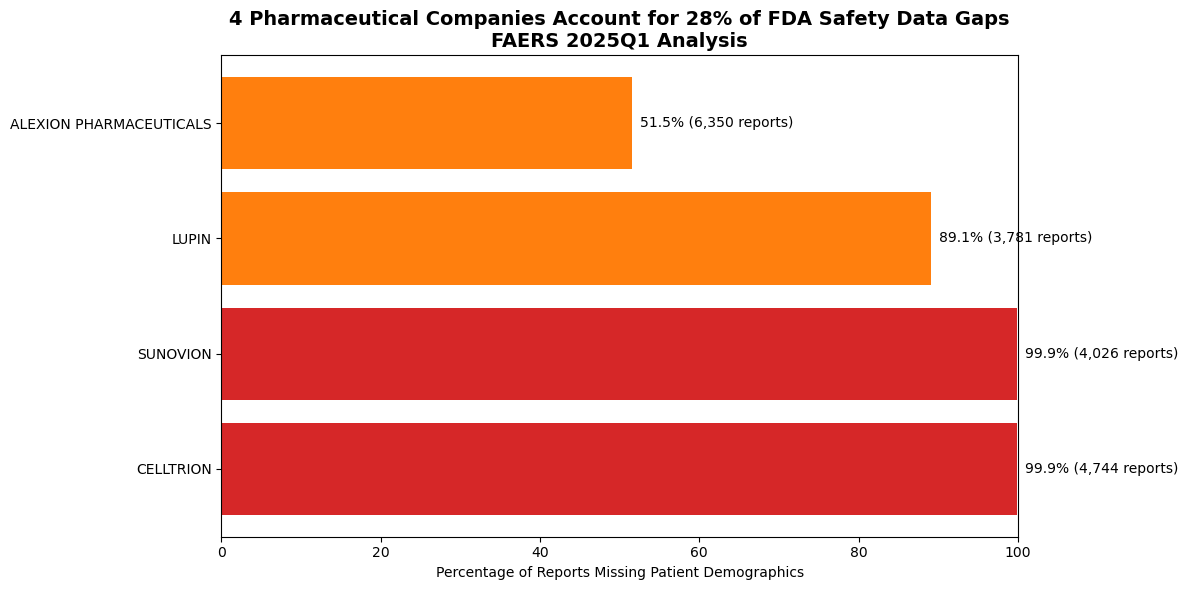

In [61]:
# The main story - 4 companies driving the problem
major_offenders = ['CELLTRION', 'SUNOVION', 'LUPIN', 'ALEXION PHARMACEUTICALS']
offender_rates = [99.94, 99.90, 89.13, 51.53]
offender_counts = [4744, 4026, 3781, 6350]

fig, ax = plt.subplots(figsize=(12, 6))
bars = ax.barh(major_offenders, offender_rates, color=['#d62728', '#d62728', '#ff7f0e', '#ff7f0e'])
ax.set_xlabel('Percentage of Reports Missing Patient Demographics')
ax.set_title('4 Pharmaceutical Companies Account for 28% of FDA Safety Data Gaps\nFAERS 2025Q1 Analysis', fontsize=14, fontweight='bold')
ax.set_xlim(0, 100)

# Add data labels
for i, (rate, count) in enumerate(zip(offender_rates, offender_counts)):
    ax.text(rate + 1, i, f'{rate:.1f}% ({count:,} reports)', va='center')

plt.tight_layout()
# Save figure to disk
plt.savefig("images/top_4_offenders.png", dpi=300, bbox_inches='tight')
plt.show()

In [62]:
# ===================================================================
# 6. VERIFICATION AND FINAL SUMMARY
# ===================================================================

print("\n=== FINAL VERIFICATION ===")
print(f"Total FAERS 2025Q1 records analyzed: {len(demo_df):,}")
print(f"Records missing ALL demographics: {len(all_missing_demo):,} ({len(all_missing_demo)/len(demo_df)*100:.1f}%)")
print(f"Companies with >90% missing demographics: {len(missing_rates[missing_rates > 90])}")
print(f"Major offenders' contribution to problem: {total_missing_from_offenders/len(all_missing_demo)*100:.1f}%")

print(f"\n=== KEY FINDINGS SUMMARY ===")
print(f"1. 17% of FDA adverse event reports lack basic patient demographics")
print(f"2. 4 pharmaceutical companies account for 28% of this data gap")
print(f"3. CELLTRION: 99.94% non-compliant (4,744/4,747 reports)")
print(f"4. SUNOVION: 99.90% non-compliant (4,026/4,030 reports)")
print(f"5. This represents potential regulatory compliance violations affecting patient safety analysis")

print(f"\nAnalysis complete. Data source: FDA FAERS 2025Q1")
print(f"Methodology: Standard data quality analysis of publicly available FDA database")



=== FINAL VERIFICATION ===
Total FAERS 2025Q1 records analyzed: 400,514
Records missing ALL demographics: 68,106 (17.0%)
Companies with >90% missing demographics: 72
Major offenders' contribution to problem: 27.8%

=== KEY FINDINGS SUMMARY ===
1. 17% of FDA adverse event reports lack basic patient demographics
2. 4 pharmaceutical companies account for 28% of this data gap
3. CELLTRION: 99.94% non-compliant (4,744/4,747 reports)
4. SUNOVION: 99.90% non-compliant (4,026/4,030 reports)
5. This represents potential regulatory compliance violations affecting patient safety analysis

Analysis complete. Data source: FDA FAERS 2025Q1
Methodology: Standard data quality analysis of publicly available FDA database


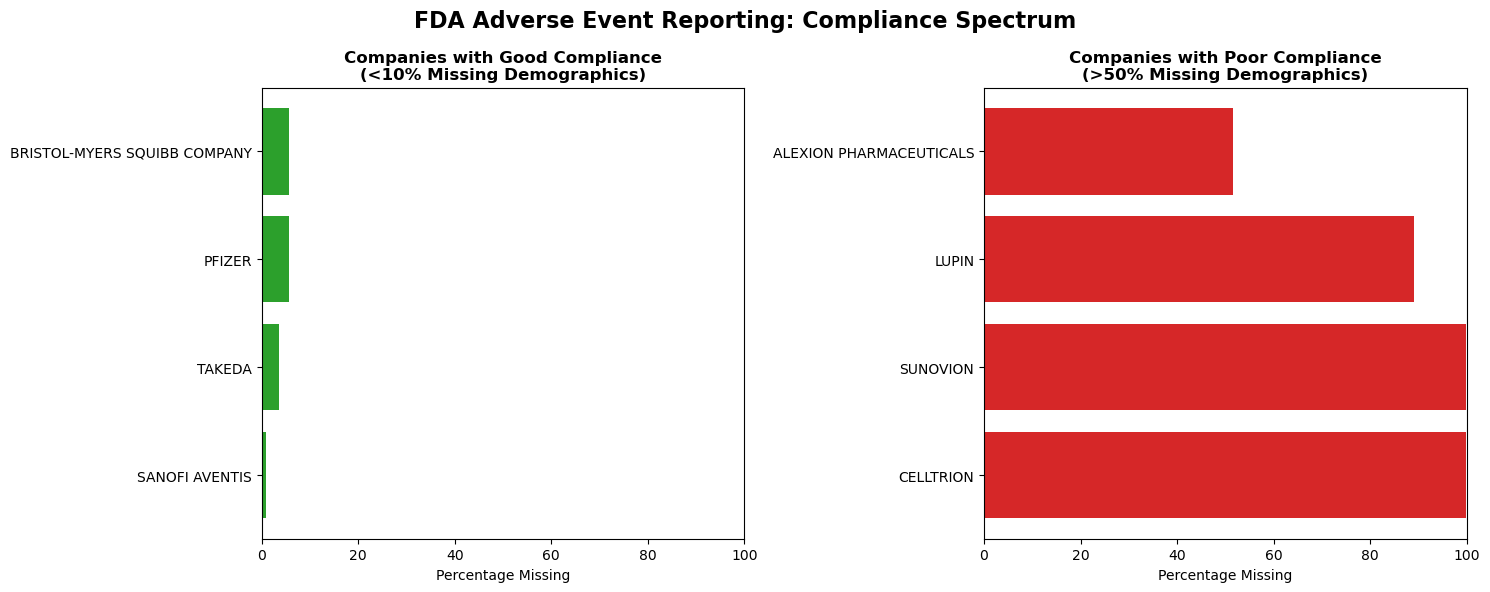

In [63]:
# Show the spectrum - some companies do it right
good_actors = ['SANOFI AVENTIS', 'TAKEDA', 'PFIZER', 'BRISTOL-MYERS SQUIBB COMPANY']
good_rates = [0.89, 3.59, 5.70, 5.68]
bad_actors = ['CELLTRION', 'SUNOVION', 'LUPIN', 'ALEXION PHARMACEUTICALS'] 
bad_rates = [99.94, 99.90, 89.13, 51.53]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Good actors
ax1.barh(good_actors, good_rates, color='#2ca02c')
ax1.set_title('Companies with Good Compliance\n(<10% Missing Demographics)', fontweight='bold')
ax1.set_xlabel('Percentage Missing')
ax1.set_xlim(0, 100)

# Bad actors  
ax2.barh(bad_actors, bad_rates, color='#d62728')
ax2.set_title('Companies with Poor Compliance\n(>50% Missing Demographics)', fontweight='bold')
ax2.set_xlabel('Percentage Missing')
ax2.set_xlim(0, 100)

plt.suptitle('FDA Adverse Event Reporting: Compliance Spectrum', fontsize=16, fontweight='bold')
plt.tight_layout()

plt.savefig('images/demographic_reporting_compliance_spectrum.png', dpi=300, bbox_inches='tight')

plt.show()

In [65]:
# Get report volumes for the 100% non-compliant companies
perfect_non_compliant = missing_rates[missing_rates == 100.0]
print("Companies with 100% missing demographics:")
for company in perfect_non_compliant.index:
    volume = demo_df[demo_df['mfr_sndr'] == company].shape[0]
    print(f"{company}: {volume:,} reports (100% missing)")

# Summary stats
volumes = [demo_df[demo_df['mfr_sndr'] == company].shape[0] 
          for company in perfect_non_compliant.index]
print(f"\nVolume range for 100% non-compliant: {min(volumes)} - {max(volumes)} reports")
print(f"Total reports from 100% non-compliant companies: {sum(volumes):,}")

Companies with 100% missing demographics:
IONIS PHARMACEUTICALS: 4 reports (100% missing)
Day One Biopharmaceuticals: 56 reports (100% missing)
IPCA: 87 reports (100% missing)
IOVANCE BIOTHERAPEUTICS: 15 reports (100% missing)
ICU MEDICAL: 13 reports (100% missing)
HEALTHCARE PHARMACEUTICALS: 1 reports (100% missing)
HARMONY BIOSCIENCES: 3 reports (100% missing)
HALOZYME: 2 reports (100% missing)
GAMIDA CELL: 3 reports (100% missing)
Fortrea: 1 reports (100% missing)
DUCHESNAY: 15 reports (100% missing)
KYOWA: 438 reports (100% missing)
DENDREON PHARMACEUTICALS LLC: 18 reports (100% missing)
DBL GROUP: 5 reports (100% missing)
CYCLE PHARMACEUTICALS: 7 reports (100% missing)
CORCEPT: 13 reports (100% missing)
CLINIGEN: 8 reports (100% missing)
BIOMARIN: 847 reports (100% missing)
BIOLOGICAL E. LIMITED: 20 reports (100% missing)
Amomed: 1 reports (100% missing)
JUBILANT - No Location Specified: 1 reports (100% missing)
MARINUS PHARMACEUTICALS: 71 reports (100% missing)
ASPEN: 36 reports 